# Understanding Frequency-Based and Distributed Word Representations

In this notebook, we will be using different word representation algorithms on a dataset.

We will be using the [Quotes-500k](https://www.kaggle.com/datasets/manann/quotes-500k) dataset in this notebook. 

The datasets consists of three columns:
- Column 1: quote (Text spoken by the author)
- Column 2: author (Speaker's name)
- Column 3: category (the category tags for the quote)

### Importing necessary libraries

In [25]:
import kagglehub
import pandas as pd
import shutil
import os
import nltk
import string
import pickle
from typing import Dict, List
import random
import numpy as np
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import matplotlib
from sklearn.manifold import TSNE
import gensim

### Download dataset from `kagglehub`

Since, `kagglehub` downloads the dataset into the `.cache` folder, we will move it to the project folder to make things easier.

In [4]:
path = kagglehub.dataset_download("manann/quotes-500k")
current_directory = os.getcwd()
destination_folder = os.path.join(current_directory, 'dataset/')
shutil.move(path, destination_folder)

print(f"Folder moved to: {destination_folder}")

100%|██████████| 89.6M/89.6M [00:02<00:00, 39.3MB/s]

Extracting files...


Folder moved to: /Users/prashanthjaganathan/Desktop/CS6120 - NLP/Codes/HW3/dataset/


Once the dataset is loaded, we can use pandas to read the `.csv` file.

In [5]:
dataset = pd.read_csv(destination_folder + 'quotes.csv')
dataset.head()

quote  \
0  I'm selfish, impatient and a little insecure. ...   
1  You've gotta dance like there's nobody watchin...   
2  You know you're in love when you can't fall as...   
3  A friend is someone who knows all about you an...   
4  Darkness cannot drive out darkness: only light...   

                                              author  \
0                                     Marilyn Monroe   
1                                  William W. Purkey   
2                                          Dr. Seuss   
3                                     Elbert Hubbard   
4  Martin Luther King Jr., A Testament of Hope: T...   

                                            category  
0  attributed-no-source, best, life, love, mistak...  
1  dance, heaven, hurt, inspirational, life, love...  
2  attributed-no-source, dreams, love, reality, s...  
3                friend, friendship, knowledge, love  
4  darkness, drive-out, hate, inspirational, ligh...

## Identify unique author names and combine all quotes by each author into a single document

To implement word representation algorithms, it's easier to convert the datset into individual documents by grouping the quotes by their authors.

In [6]:
unique_author_names = dataset['author'].unique().tolist()
print(f"Number of authors: {len(unique_author_names)}")
print(unique_author_names)

Number of authors: 117297
['Marilyn Monroe', 'William W. Purkey', 'Dr. Seuss', 'Elbert Hubbard', 'Martin Luther King Jr., A Testament of Hope: The Essential Writings and Speeches', 'Stephen Chbosky, The Perks of Being a Wallflower', 'Bob Marley', 'André Gide, Autumn Leaves', 'John Green, The Fault in Our Stars', 'Elie Wiesel', 'Friedrich Nietzsche', 'Pablo Neruda, 100 Love Sonnets', "William Shakespeare, All's Well That Ends Well", 'Neil Gaiman, The Kindly Ones', 'Lao Tzu', 'Sarah Dessen, The Truth About Forever', 'Robert A. Heinlein, Stranger in a Strange Land', 'Suzanne Collins, Mockingjay', 'Nicholas Sparks, The Notebook', "William Shakespeare, A Midsummer Night's Dream", 'Nicholas Sparks, A Walk to Remember', 'Elizabeth Gilbert, Eat, Pray, Love', "Jodi Picoult, My Sister's Keeper", 'Robert Fulghum, True Love', 'Anaïs Nin', 'Jane Austen, Northanger Abbey', 'Alfred Tennyson', 'C.S. Lewis, The Four Loves', 'Jess C. Scott, The Intern', 'J.K. Rowling, Harry Potter and the Deathly Hallow

In [7]:
nltk.download('stopwords')
# NOTE: Here, we are assuming the quotes are in English 
#       Let's remove too frequently occuring stop words using `nltk` stopwords

stopwords = nltk.corpus.stopwords.words('english') 

# NOTE: If we do not need the `nltk` library then we can just uncomment the below line
# stopwords = ['a', 'and', 'the', 'but', 'or', 'in', 'on', 'at', 'with', 
#              'he', 'she', 'it', 'they', 'is', 'as', 'was', 'were']

translator = str.maketrans('', '', string.punctuation)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/prashanthjaganathan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


It's a good practice in NLP to first preprocess the dataset by:
- converting words to lower case
- removing punctuation
- removing stopwords

However, the above steps are not necessary and depends on the use case

In [8]:
# Since, we are doing TF-IDF here let's split the quotes by words and do basic pre-processing
def preprocess_text(quote: str):
    # Convert to lower case
    quote = quote.lower()

    # Remove punctuations
    quote = quote.translate(translator)

    # Removing stop words
    # NOTE: Reffered to this article by GFG for stopwords removal using nltk (https://www.geeksforgeeks.org/removing-stop-words-nltk-python/)
    words = quote.split()
    processed_quote = [word for word in words if word not in stopwords]
    return processed_quote

In [9]:
author_quotes_doc: Dict[str, list[str]] = {}
completed = 0

for author_name in unique_author_names:
    author_quotes = dataset[dataset['author'] == author_name]['quote']
    # Let's preprocess the author quotes before loading it to our document.
    # `processed_author_quotes` is a list of all words used by the author bundled together after pre-processing
    processed_author_quotes: list = [word for quote in author_quotes for word in preprocess_text(quote)]

    if author_name not in author_quotes_doc.keys():
        author_quotes_doc[author_name] = processed_author_quotes
    else:
        author_quotes_doc[author_name].append(word for word in processed_author_quotes)
    
    completed += 1
    if completed % 10000 == 0:
        print(f'Processed {completed} authors')

Processed 10000 authors
Processed 20000 authors
Processed 30000 authors
Processed 40000 authors
Processed 50000 authors
Processed 60000 authors
Processed 70000 authors
Processed 80000 authors
Processed 90000 authors
Processed 100000 authors
Processed 110000 authors


Since, pre-processing the entire dataset takes time, let's store what was pre-processed so we can load them at our conveniance

In [ ]:
# Writing the processed quotes dict into a file
# with open('models/author_quotes.pkl', 'wb') as file:
#     pickle.dump(author_quotes_doc, file)

# Loading the dict from the pickle file
with open('models/author_quotes.pkl', 'rb') as file:
    author_quotes_doc = pickle.load(file)

print(len(author_quotes_doc))

117297


**NOTE**

`author_quotes_doc` has the format: 

{

    'author_name': [List of words used by the author - repeating],

    ......
    
}

So, each author name and the corresponding words used by the author is considered as a document in this case.

### Let's pick three random authors and print their two most frequently used words (size > 4)

In [20]:
random_author_names = random.sample(unique_author_names, 3)
random_author_names

['Garry Douglas Kilworth, The Wizard Of Woodworld',
 'Meek Mill',
 'R.W. Schmidt, The Lands Beyond the Moon']

In [21]:
total_docs_in_corpus = None

In [10]:
# The below methods calculates different metrics which are necessary to calculate the TF-IDF scores

def calc_frequency(word_list, term):
    return sum(1 for word in word_list if word == term)

def calc_total_docs_containing_term(total_docs_in_corpus, term):
    return sum(1 for _, words in total_docs_in_corpus.items() if term in words)

def compute_tf_idf(total_docs_in_corpus: Dict[str, List[str]], current_doc, word):
    tf_score = calc_frequency(current_doc, word) / len(current_doc)
    df = calc_total_docs_containing_term(total_docs_in_corpus, word)
    idf_score = np.log(len(total_docs_in_corpus) / (df if df != 0 else 1))
    print(f'TF Score: {tf_score}')
    print(f'IDF Score: {idf_score}')
    tf_idf_score = tf_score * idf_score

    return tf_idf_score

## Let's compute the TF-IDF representations and compare the values for each document.

Since, the two most frequent words used by the three randomly selected authors are 'people' and 'like' in this execution, let's calculate their TF-IDF scores in each of the three documents

In [72]:
subset_corpus = {name: author_quotes_doc[name] for name in random_author_names}
print(subset_corpus)

word_frequencies = {}
# Create frequency dictionary and sort by values
for _, words in subset_corpus.items():
    # Calculate word frequencies for author
    for word in words:
        if word not in word_frequencies:
            word_frequencies[word] = 0
        word_frequencies[word] += 1

# Sort by frequency values in descending order
sorted_words = sorted(word_frequencies.items(), 
                        key=lambda x: x[1],  # x[1] refers to the frequency value
                        reverse=True)        # reverse=True for descending order


count = 0
most_frequent_words = []

for (word, freq) in sorted_words:
    if len(word) >= 4:
        most_frequent_words.append((word, freq))
        count += 1

        if count == 2:
            break
    
print(f"\nTop 2 frequent words used by the 3 authors\n{most_frequent_words}\n\n")

# Create frequency dictionary and sort by values
for idx, (author_name, words)in enumerate(subset_corpus.items()):
    for (word, freq) in most_frequent_words:
        print(f'TF-IDF representation of "{word}" in doc {author_name}: {compute_tf_idf(subset_corpus, words, word)}\n')

    print('----------------------------------------\n')


{'Garry Douglas Kilworth, The Wizard Of Woodworld': ['one', 'never', 'fight', 'country', 'one', 'fight', 'one', 'one', 'believes', 'right', 'country', 'good', 'leading', 'citizens', 'wouldnt', 'nice', 'find', 'world', 'peace', 'matter', 'always', 'wanted', 'others', 'satisfied', 'running', 'lives', 'wishing', 'power', 'lives', 'others', 'greedy', 'people', 'greedy', 'wealth', 'power'], 'Meek Mill': ['cool', 'people', 'know', 'like', 'people', 'treat', 'regular', 'see', 'take', 'pictures', 'dont', 'really', 'big', 'people', 'looking', 'dont', 'rely', 'catchphrases', 'really', 'like', 'singalong', 'whatever', 'feel', 'whatever', 'beat', 'makes', 'say', 'run', 'working', 'id', 'cool', 'work', 'harder', 'anybody', 'youve', 'ever', 'seen', 'thats', 'believe', 'everybody', 'think', 'theyre', 'famous', 'get', '100000', 'followers', 'instagram', '5000', 'twitter', 'dont', 'like', 'girl', 'social', 'media', 'open', 'inbox', 'answering', 'questions', 'dudes', 'left', 'right', 'every', 'day', 'wh

**The output above represents the words and their corresponding TF-IDF representation**

## Word2Vec

Next, let's try the Word2Vec algorithm by training a Word2Vec skip-gram model on the corpus using **Gensim**.

In [ ]:
# Let's bundle all documents together
def preprocess_for_word2vec(corpus: Dict[str, list[str]]):
    combined_docs = []
    for _, words in corpus.items():
        combined_docs.append(words)

    return combined_docs

combined_docs = preprocess_for_word2vec(author_quotes_doc)

Let's experiment with two configurations:
- [Context window size: 3, Vector dimensions: 50, Negative samples: 3]
- [Context window size: 7, Vector dimensions: 150, Negative samples: 10]

In [82]:
# Train a Word2Vec model (Skip-gram)
model_config1 = Word2Vec(sentences=combined_docs, vector_size=50, window=3, sg=1, negative=3)
model_config2 = Word2Vec(sentences=combined_docs, vector_size=150, window=7, sg=1, negative=10)

In [14]:
# model_config1.save("models/word2vec_model1.model")
# model_config2.save("models/word2vec_model2.model")

# Load the models from the saved files
model_config1 = Word2Vec.load("models/word2vec_model1.model")
model_config2 = Word2Vec.load("models/word2vec_model2.model")

In [15]:
# Evaluating model 1
print(f'Words similar to "imagination": {model_config1.wv.most_similar(positive=["imagination"], topn=5)}')
print(f'Cosine similarity between "fear" and "knowledge": {model_config1.wv.similarity("fear", "knowledge")}')


Words similar to "imagination": [('figment', 0.8131558299064636), ('overactive', 0.800955057144165), ('imaginative', 0.7953220009803772), ('creativity', 0.7942456603050232), ('imaginations', 0.7829957008361816)]
Cosine similarity between "fear" and "knowledge": 0.4456808567047119


In [16]:
# Evaluating model 2
print(f'Words similar to "imagination": {model_config2.wv.most_similar(positive=["imagination"], topn=5)}')
print(f'Cosine similarity between "fear" and "knowledge": {model_config2.wv.similarity("fear", "knowledge")}')


Words similar to "imagination": [('imaginations', 0.7187469005584717), ('overactive', 0.691013753414154), ('figment', 0.6618826985359192), ('imaginative', 0.648589015007019), ('creativity', 0.6480312347412109)]
Cosine similarity between "fear" and "knowledge": 0.37986859679222107


**Observation**

Model 1 shows stronger word associations for "imagination" and a higher cosine similarity (~ 0.45) between "fear" and "knowledge," indicating better performance. 

Model 2 has weaker associations and a slightly lower similarity score (~ 0.38), suggesting it's less effective at capturing these relationships. Overall, Model 1 seems to perform better in both cases.

## TSNE visualization of Embeddings

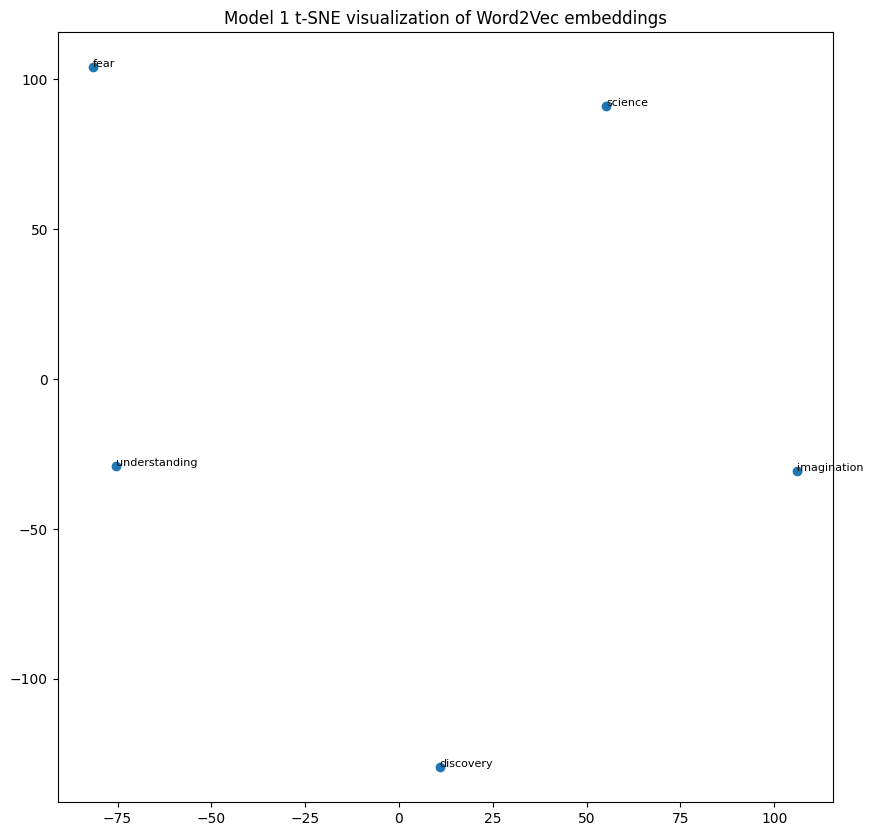

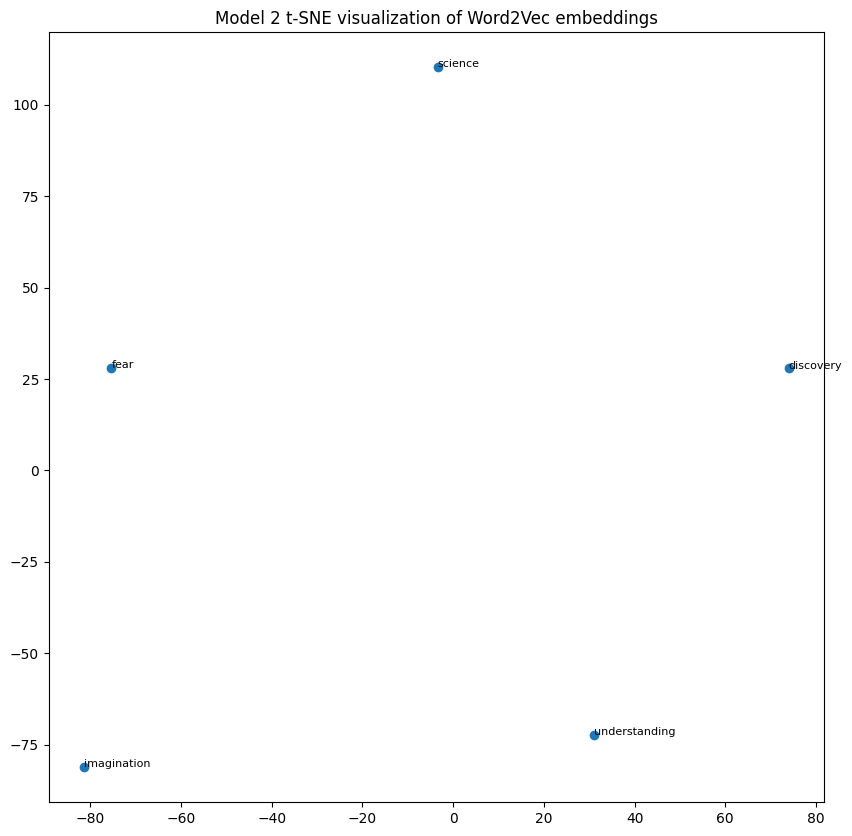

In [26]:
def visualize_words(model_path, model_name):
    """Function to visualize Word2Vec words"""
    
    # Load the Word2Vec model
    model = gensim.models.Word2Vec.load(model_path)
    vocab = ["imagination", "fear", "understanding", "discovery", "science"]
    
    # Extract word vectors for each word in the vocabulary
    vectors = np.array([model.wv[word] for word in vocab])

    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, random_state=0, perplexity=4)
    X_tsne = tsne.fit_transform(vectors)

    # Create a DataFrame with t-SNE results
    df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])

    _, ax = plt.subplots(figsize=(10, 10))

    ax.scatter(df['x'], df['y'])

    # Annotate words on the scatter plot
    for word, pos in df.iterrows():
        ax.annotate(word, pos, fontsize=8)

    ax.set_title(f"{model_name} t-SNE visualization of Word2Vec embeddings")
    plt.show()

models_folder = os.path.join(current_directory, 'models/')
visualize_words(models_folder + 'word2vec_model1.model', 'Model 1')
visualize_words(models_folder + 'word2vec_model2.model', 'Model 2')

**Observation**

From both the visualizations, though we can't really give an actual right answer because the embeddings dimensions were reduced which could have removed some semantics. But, overall Model 1 seems to have stronger relationships as the words 'science', 'discovery', 'imagination', and 'understanding' can be related and also appear relatievly closer to each other compared to Model 2.

## Visualizing the Embeddings

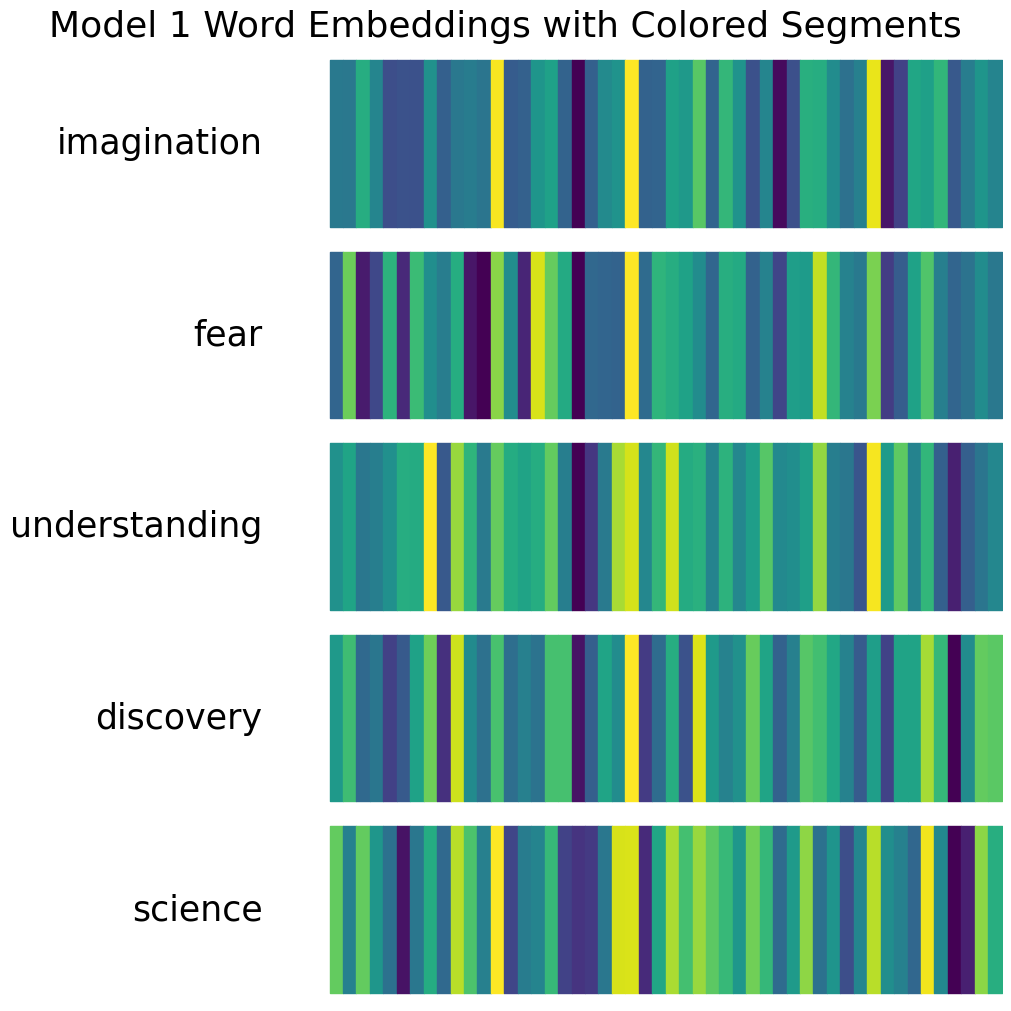

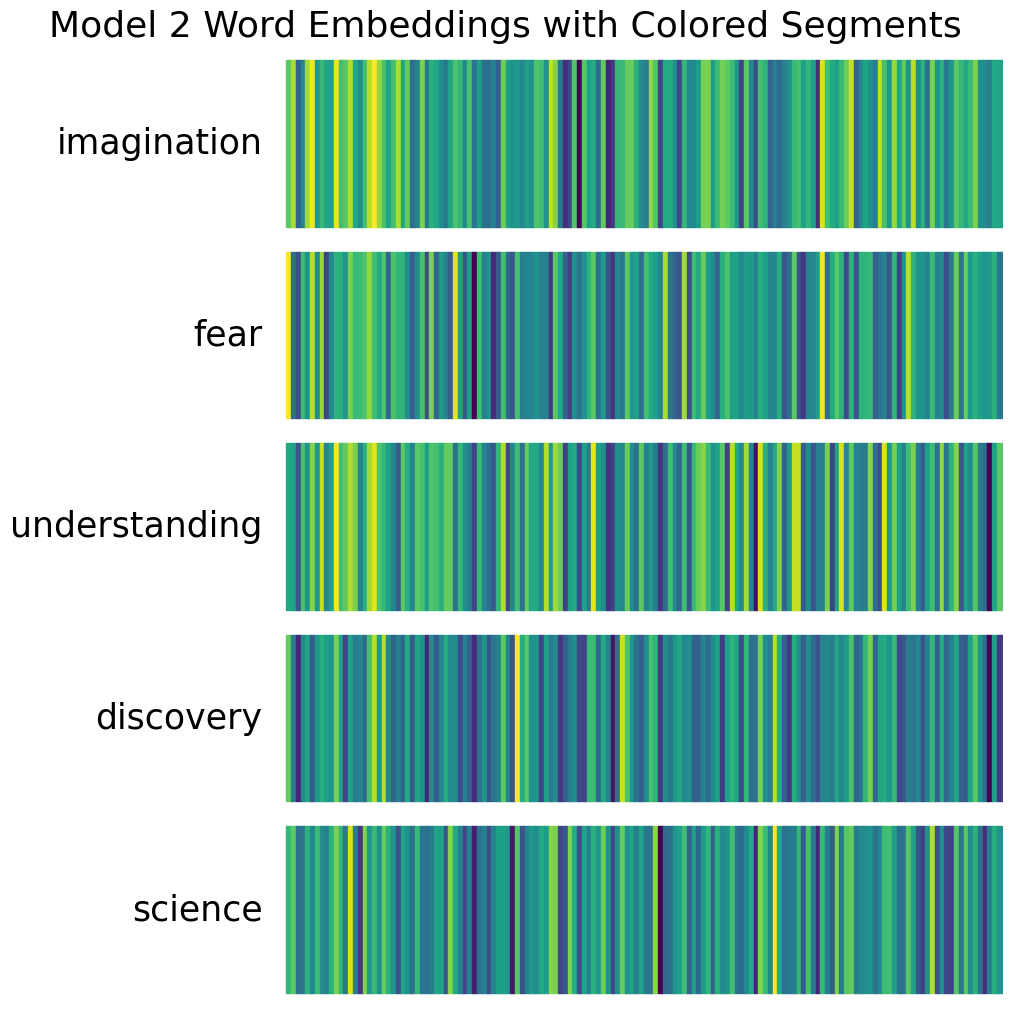

In [ ]:
# Set font size for better readability in the plot
matplotlib.rcParams.update({'font.size': 25})

words = ['imagination', 'fear', 'understanding', 'discovery', 'science']

def visualize_embeddings_with_cmap(model, words, model_name):
    """Function to visualize the word embeddings using colored segments"""
    # Prepare the plot
    _, axs = plt.subplots(len(words), 1, figsize=(10, len(words) * 2), constrained_layout=True)
    if len(words) == 1:
        axs = [axs]

    label_offset = -5 

    for ax, word in zip(axs, words):
        if word in model.wv:
            vector = model.wv[word]

            # Normalize the vector to [0, 1]
            normalized_vector = (vector - np.min(vector)) / (np.max(vector) - np.min(vector))
            
            # Get color mapping from the normalized vector
            cmap = plt.get_cmap('viridis')
            colors = cmap(normalized_vector)
            
            # Plot each dimension as a colored segment
            for i, color in enumerate(colors):
                ax.fill_between([i, i + 1], 0, 1, color=color)
            
            ax.set_xlim(label_offset, len(vector))  # Adjust x-axis to fit the vector size
            ax.axis('off')  # Turn off the axis
            # Place the word label to the left of the vector
            ax.text(label_offset, 0.5, word, verticalalignment='center', horizontalalignment='right')

        else:
            ax.axis('off')  # If the word is not in the vocabulary, just turn off the axis
            ax.text(label_offset, 0.5, f'"{word}" - Not in vocabulary', verticalalignment='center', horizontalalignment='right', color='red')

    plt.suptitle(f"{model_name} Word Embeddings with Colored Segments", fontsize=26)
    plt.show()

# Visualize the embeddings for both models
visualize_embeddings_with_cmap(model_config1, words, model_name="Model 1")
visualize_embeddings_with_cmap(model_config2, words, model_name="Model 2")


From the above visualizations we can see that all the 5 words have somewhat similar embeddings color maps, portraying that they similar embeddings.

#### **How context and dimensionality impact relationships in embeddings**

- Dimensions play a critical role in encoding semnatic relations in an embedding. Generally, higher dimensions would allow more meaning to be encoded into the embedding vector. But, however this would depend on the use case as sometimes a slightly lower dimensional vector embedding could prove to perfom better for the task at hand. It is important to note that higher dimensions would greatly increase the cost of computation, which must always be accounted when working with embeddings. 

- Contexts help capture different meanings of a word in different scenariois. It helps understand the relationships between the vectors better. Generally, a larger context window would help the model understand wider range of meanings of the word in different scenarios.

Both context and dimensionality play a crucial role in identifying a good set of embeddings for the task at hand. It is important to find the best values that increases the combined effect of these factors.


